In [1]:
import pandas as pd
import matplotlib.pyplot as plt

First I want to read in the user engagement CSV so I can get a list of all adopted users. This will be my target in the second section. Code below will read in the csv, parse dates to datetime and pull out the year and week of each login. 

In [2]:
time_stamps = pd.read_csv('takehome_user_engagement.csv',parse_dates = ['time_stamp'])
time_stamps = time_stamps.sort_values('time_stamp')
time_stamps['year'] = time_stamps['time_stamp'].dt.year
time_stamps['week'] = time_stamps['time_stamp'].dt.week
display(time_stamps.info())
display(time_stamps.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 178140 to 70763
Data columns (total 5 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
year          207917 non-null int64
week          207917 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 9.5 MB


None

,time_stamp,user_id,visited,year,week
178140,2012-05-31 08:20:06,10012,1,2012,22
59486,2012-05-31 15:47:36,3428,1,2012,22
175638,2012-05-31 17:19:37,9899,1,2012,22
26821,2012-05-31 21:58:33,1693,1,2012,22
109716,2012-06-01 00:17:30,6102,1,2012,22


Grouping by the year, then the week and then the user id with an aggregation by count will allow me to see the users who have logged in more than 3 times in any given week. Boolean filtering on visits >= 3 and pulling out a unique list of these users returns all the adopted users.

In [3]:

logins_per_week = time_stamps.groupby(['year','week','user_id']).count()
three_or_more = logins_per_week[logins_per_week.visited >= 3].reset_index()
adopted_users = list(three_or_more.user_id.unique())


Now lets read in the second csv. Had to change the encoding from utf-8, I suspect because of the email address @ symbol. Looking at the dataframe it's clear that several columns need to be cleaned and tinkered with to enable analysis. First we'll make a target column, 1 denoting adopted user. Then we'll change the column invited by user id into a far more simple binary variable that says whether a given user was invited or found the platform themselves (assuming the NaN values in this column are due to not being invited and not some other flaw in data collection). Creation source will have to be pushed to a dummy variable for modeling, which we'll do with pandas get dummies function right before modeling. Finally we'll drop the columns that are useless for predictive modeling, name, email, last session creation and invited by user. Invited by user I thought about keeping for awhile, but it will be mostly populated by users who invited 1 other user who adopted and the inverse of that (users who invited 1 other user who did not adopt). This then becomes not useful in prediction, just adding lots of extra noise. Potentially binning the users into numbers of invites sent could add valuable information. 

In [4]:
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
users.creation_time = pd.to_datetime(users.creation_time)

users['adopted'] = 0
users.loc[users['object_id'].isin(adopted_users),'adopted'] = 1

users.drop(['name','email','last_session_creation_time','creation_time','invited_by_user_id','object_id'],axis=1,inplace=True)
display(users.head())
display(users.info())

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
adopted                       12000 non-null int64
dtypes: int64(4), object(1)
memory usage: 468.8+ KB


None

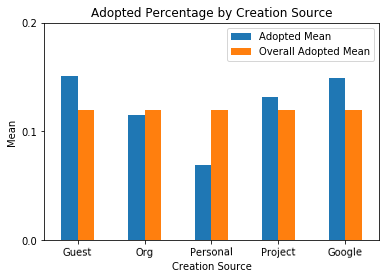

In [5]:
creation = pd.DataFrame(users[['creation_source','adopted']].groupby(['creation_source']).mean())
creation['Overall Adopted Mean'] = 0.12
creation.rename({'adopted':'Adopted Mean'},axis=1,inplace=True)
axis = ['Guest','Org','Personal','Project','Google']
creation.index = axis
creation.plot.bar(title = 'Adopted Percentage by Creation Source',rot=1)
plt.xlabel('Creation Source')
plt.ylabel('Mean')
plt.yticks([0.0,0.10,0.20])
plt.show()

In [6]:
org_adoption = pd.DataFrame(users[['org_id','adopted']].groupby('org_id').mean().sort_values(by='adopted',ascending=False))
display(org_adoption[0:10])
org_adoption.reset_index(inplace=True)
cut = pd.cut(org_adoption['org_id'], bins = 3,labels = ['0','1','2'])
cut_dict = cut.to_dict()
users['org_id'] = users['org_id'].map(cut_dict)

,adopted
org_id,
387,0.500000
235,0.461538
270,0.428571
399,0.384615
415,0.375000
400,0.375000
345,0.357143
318,0.352941
161,0.333333


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [9]:
users_dummies = pd.get_dummies(users)
X = users_dummies.drop('adopted',axis =1 )
y = users_dummies['adopted']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

First we have to get dummy variables for our feature creation source. Then we can set a training and testing set. Because of the large class imbalance I decided to use an oversampling method on the positive class (adopted the platform). This method is called SMOTE or synthetic minority oversampling technique. This uses the k-nearest neighbors algorithm to create new instances of the the positive class that are slightly tweaked from original observations. The primary worry here is overfitting to the training set if I only oversample on the training set, or leakage of information into my testing set if I resample the whole data set. I only oversampled on the training set, we'll see if this has an effect on ovefitting of the model. 

Running a grid search CV with 5 folds returned the optimal parameters you see below. The ROC curve and AUC score are reproduced below. This RF model has an AUC of 0.61 for the positive class. Not terrible given the rarity of the class.

I also looked at an SVM model and a logisitic regression without much success.

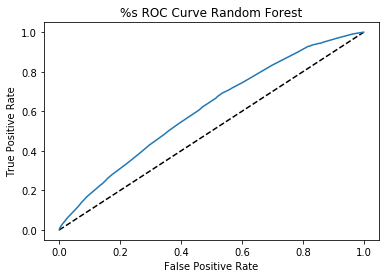

0.6094481007118245


In [10]:
#params = {'n_estimators': [1,2,4,8,16,32,64,128],'max_depth':np.linspace(1,15)}
#cv = GridSearchCV(estimator = RandomForestClassifier(),scoring = 'roc_auc', param_grid = params, cv = 5)
#cv.fit(X_train,y_train)
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train,y_train)
rf = RandomForestClassifier(n_estimators=32,max_depth=5)
rf.fit(X_train,y_train)
y_prob = rf.predict_proba(X_train)
fpr, tpr, thresholds  = metrics.roc_curve(y_train, y_prob[:,1])
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve Random Forest')
plt.show()
print(metrics.roc_auc_score(y_train,y_prob[:,1]))

In [12]:
print(metrics.classification_report(y_test,rf.predict(X_test)))
y_true = pd.Series(y_test)
y_pred = pd.Series(rf.predict(X_test))

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.90      0.49      0.64      2624
           1       0.15      0.60      0.23       376

   micro avg       0.51      0.51      0.51      3000
   macro avg       0.52      0.55      0.44      3000
weighted avg       0.80      0.51      0.59      3000



Predicted,0,1,All
True,,,
0,298,361,659
1,37,53,90
All,335,414,749


In [30]:
pd.DataFrame({'Features': X.columns, 'Importance': rf.feature_importances_}).sort_values('Importance',ascending=False)
display()

,Features,Importance
4,creation_source_PERSONAL_PROJECTS,0.397660
1,enabled_for_marketing_drip,0.117315
0,opted_in_to_mailing_list,0.094401
7,org_id_0,0.084178
2,creation_source_GUEST_INVITE,0.069434
3,creation_source_ORG_INVITE,0.051203
6,creation_source_SIGNUP_GOOGLE_AUTH,0.050785
9,org_id_2,0.050704
5,creation_source_SIGNUP,0.046101
8,org_id_1,0.038220


In [34]:
display(users_dummies.creation_source_PERSONAL_PROJECTS.corr(users.adopted))
display(users.enabled_for_marketing_drip.corr(users.adopted))
display(users.opted_in_to_mailing_list.corr(users.adopted))

-0.07266856230705579

0.006009708561776501

0.01048983897460246

I've also looked at a confusion matrix to see where the model goes wrong and a listing of feature importances. Unsurprisingly, users who signed up for personal projects are the best predictor of adopting the platform. We saw this above, only a small percentage of users who join for personal reasons stick around. After that we have enabled for marketing drip with slightly positively predicts adoption and opted into mailing list which does as well. Given this information, it might make sense to target the individuals who signed up for a personal project and see if we can get them signed up on the marketing drip, or associated with an organization!